# Tomato Leaf Disease Detection using YOLO Models

This notebook is the start to a comparative study of different YOLO versions (YOLOv8, YOLOv9, YOLO11) for detecting diseases in tomato leaves. Only training is done here.

## Setup and Imports

### Library Imports
The following libraries are used:
- `yaml`: For parsing configuration files
- `torch`: Deep learning framework for model operations, mainly for being able to use cuda
- `pathlib`: For cross-platform file path handling
- `matplotlib` & `seaborn`: For creating visualizations and plots
- `datetime`: For timestamp management
- `pandas`: For structured data manipulation
- `numpy`: For numerical computations
- `ultralytics`: For YOLO model implementation

### Seeds and Configuration
- Setting torch seed (43) for reproducible model behavior
- Setting numpy seed (42) for consistent data operations

In [1]:
import yaml
import torch
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np
from ultralytics import YOLO

torch.manual_seed(43)
np.random.seed(42)

## Configuration and Experiment Tracking

1. `ModelConfig`: Handles all training configurations including:
   - Basic parameters (image size, batch size, epochs)
   - Learning rate scheduling
   - Regularization parameters
   - Data augmentation settings
   - Early stopping criteria

2. `ExperimentTracker`: Manages experiment logging and visualization:
   - Tracks training and validation metrics
   - Saves results to CSV
   - Generates training curves

These classes help maintain consistent configuration across different YOLO versions and provide systematic experiment tracking.

In [2]:
# Create a base configuration class
class ModelConfig:
    def __init__(self):
        self.data_dir = Path("tomato-leaf-diseases")
        self.img_size = 640
        self.batch_size = 8
        self.epochs = 50
        self.num_classes = 7
        
        # Learning rate scheduling
        self.initial_lr = 0.01
        self.final_lr = 0.001
        
        # Regularization
        self.weight_decay = 0.0005
        self.dropout = 0.2
        
        # Data augmentation parameters
        self.augmentation = {
            'hsv_h': 0.015,
            'hsv_s': 0.7,
            'hsv_v': 0.4,
            'degrees': 0.0,
            'translate': 0.1,
            'scale': 0.5,
            'shear': 0.0,
            'flipud': 0.0,
            'fliplr': 0.5,
            'mosaic': 0,
            'device': 0,
            'mixup': 0.0
        }
        
        # Early stopping parameters
        self.patience = 10
        self.min_delta = 0.001

# Create experiment tracking class
class ExperimentTracker:
    def __init__(self, model_name):
        self.model_name = model_name
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.metrics = {
            'train_loss': [],
            'val_loss': [],
            'mAP50': [],
            'mAP50_95': []
        }
        
    def update(self, epoch, metrics):
        for k, v in metrics.items():
            self.metrics[k].append(v)
            
    def save_results(self):
        results_dir = Path('results') / self.model_name / self.timestamp
        results_dir.mkdir(parents=True, exist_ok=True)
        
        # Save metrics
        pd.DataFrame(self.metrics).to_csv(results_dir / 'metrics.csv')
        
        # Plot training curves
        self.plot_training_curves(results_dir)
        
    def plot_training_curves(self, save_dir):
        plt.figure(figsize=(15, 5))
        
        # Loss curves
        plt.subplot(1, 2, 1)
        plt.plot(self.metrics['train_loss'], label='Train Loss')
        plt.plot(self.metrics['val_loss'], label='Val Loss')
        plt.title(f'{self.model_name} Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # mAP curves
        plt.subplot(1, 2, 2)
        plt.plot(self.metrics['mAP50'], label='mAP@0.5')
        plt.plot(self.metrics['mAP50_95'], label='mAP@0.5:0.95')
        plt.title(f'{self.model_name} mAP Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('mAP')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(save_dir / 'training_curves.png')
        plt.close()

## Training Setup and Data Configuration

This section contains the core training functionality:

1. `train_yolo`: Main training function that:
   - Handles different YOLO versions
   - Sets up model paths and experiment tracking
   - Configures and executes training
   - Returns trained model and results

2. `create_data_yaml`: Creates the YAML configuration file required by YOLO:
   - Defines dataset paths
   - Specifies class names
   - Sets up training/validation/test splits

### Dataset Structure
The dataset contains 7 classes:
- Bacterial Spot
- Early Blight
- Healthy
- Late Blight
- Leaf Mold
- Target Spot
- Black Spot

In [3]:
def train_yolo(config, model_name):
    """
    Main training function which trains the particular model by using parameters from the config file.

    Args:
        config: config file which has all the necessary training hyperparameters
        model_name: the model that is being trained
        
    Returns:
        model: original model
        results: model trained on the train dataset
        tracker: not currently being used
    """
    
    # Extract YOLO version from model_name (e.g., 'yolov8n.pt' -> '8')
    if(model_name == 'yolo11s.pt'):
        yolo_version = '11' # Except for yolo11 because it does not have a 'v'
    else:
        yolo_version = model_name.split('v')[1][0]
    
    # Create pretrained models directory
    pretrained_dir = Path('pretrained_models')
    pretrained_dir.mkdir(exist_ok=True)
    
    # Initialize experiment tracker with appropriate name
    tracker = ExperimentTracker(f'YOLOv{yolo_version}')
    
    # Initialize model
    model = YOLO(pretrained_dir / model_name)
    
    # Prepare training arguments with dynamic naming
    args = dict(
        data='data.yaml',
        epochs=config.epochs,
        imgsz=config.img_size,
        batch=config.batch_size,
        patience=config.patience,
        device='0' if torch.cuda.is_available() else 'cpu',
        project='runs/train',
        name=f'yolov{yolo_version}_exp_{tracker.timestamp}'
    )
    
    # Train model
    results = model.train(**args)
    return model, results, tracker

def create_data_yaml():
    '''
    Creates the data.yaml file required by YOLO.
    '''
    data = {
        'path': str(Path('tomato-leaf-diseases').absolute()),
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'names': [
            'Bacterial Spot',
            'Early_Blight',
            'Healthy',
            'Late_blight',
            'Leaf Mold',
            'Target_Spot',
            'black spot'
        ],
        'nc': 7  # number of classes
    }
    
    with open('data.yaml', 'w') as f:
        yaml.dump(data, f)

In [4]:
# Creating the config file and data.yaml file as per YOLO requirements
config = ModelConfig()
create_data_yaml()

## Training YOLOv8n

In [7]:
model, results, tracker = train_yolo(config, 'yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 13.5MB/s]


Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: task=detect, mode=train, model=pretrained_models\yolov8n.pt, data=data.yaml, epochs=50, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs/train, name=yolov8_exp_20250118_173358, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

100%|██████████| 5.35M/5.35M [00:00<00:00, 14.7MB/s]


AMP: checks passed 


train: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\train\labels.cache... 645 images, 18 backgrounds, 0 corrupt: 100%|██████████| 645/645 [00:00<?, ?it/s]
val: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\valid\labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]


Plotting labels to runs\train\yolov8_exp_20250118_173358\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\train\yolov8_exp_20250118_173358
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.22G      1.509      3.389      1.268         18        640: 100%|██████████| 81/81 [00:13<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

                   all         61        196      0.959      0.105      0.224      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.21G      1.444      2.378      1.231         26        640: 100%|██████████| 81/81 [00:10<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

                   all         61        196      0.467      0.284      0.256      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.23G      1.412      2.161       1.21         15        640: 100%|██████████| 81/81 [00:09<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

                   all         61        196      0.371      0.385      0.299      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       1.2G      1.402      2.009      1.202         24        640: 100%|██████████| 81/81 [00:09<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]

                   all         61        196      0.813      0.322      0.323      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.23G      1.369      1.923      1.191         12        640: 100%|██████████| 81/81 [00:09<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

                   all         61        196      0.778      0.381      0.389      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.22G      1.311      1.732      1.157         30        640: 100%|██████████| 81/81 [00:09<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.51it/s]

                   all         61        196      0.841      0.288      0.351      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.21G      1.306      1.646      1.162         14        640: 100%|██████████| 81/81 [00:09<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.69it/s]

                   all         61        196      0.585      0.445      0.446      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.19G      1.271      1.498      1.168         10        640: 100%|██████████| 81/81 [00:09<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.96it/s]

                   all         61        196      0.718      0.437      0.455      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.23G      1.221      1.469      1.122         24        640: 100%|██████████| 81/81 [00:09<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

                   all         61        196      0.684      0.502      0.497      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.23G      1.237      1.352      1.113         33        640: 100%|██████████| 81/81 [00:09<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

                   all         61        196      0.503      0.501      0.494      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.23G      1.243      1.329      1.116         11        640: 100%|██████████| 81/81 [00:10<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

                   all         61        196      0.489      0.509      0.489      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.23G      1.174      1.261      1.082         27        640: 100%|██████████| 81/81 [00:09<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

                   all         61        196      0.664      0.488       0.56       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.25G      1.178      1.254      1.091         13        640: 100%|██████████| 81/81 [00:09<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all         61        196      0.469      0.655      0.571      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.22G      1.173      1.182      1.079         10        640: 100%|██████████| 81/81 [00:09<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all         61        196      0.591      0.635      0.589      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.23G      1.163      1.132      1.078         23        640: 100%|██████████| 81/81 [00:09<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]

                   all         61        196      0.637      0.613      0.601      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.23G      1.131      1.113      1.071         29        640: 100%|██████████| 81/81 [00:09<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.43it/s]

                   all         61        196      0.577        0.6       0.55      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.24G      1.137      1.092      1.065         19        640: 100%|██████████| 81/81 [00:09<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.06it/s]

                   all         61        196       0.65      0.653      0.648      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.23G      1.127      1.033      1.058         26        640: 100%|██████████| 81/81 [00:09<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.66it/s]

                   all         61        196      0.628      0.611        0.6      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.25G      1.148      1.045      1.057         18        640: 100%|██████████| 81/81 [00:09<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]

                   all         61        196      0.696      0.631      0.619      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.19G      1.104     0.9974       1.06         29        640: 100%|██████████| 81/81 [00:09<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

                   all         61        196      0.721      0.633      0.682      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.23G      1.081     0.9693      1.043         24        640: 100%|██████████| 81/81 [00:09<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]

                   all         61        196      0.703      0.652      0.652      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.22G       1.07     0.9528       1.05         14        640: 100%|██████████| 81/81 [00:09<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]

                   all         61        196      0.585      0.621      0.614       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.23G      1.087     0.9373      1.029         24        640: 100%|██████████| 81/81 [00:09<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all         61        196      0.623       0.67      0.641       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       1.2G       1.03     0.9143      1.032         25        640: 100%|██████████| 81/81 [00:09<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.03it/s]

                   all         61        196      0.612      0.613      0.631      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.23G      1.085      0.891       1.03         32        640: 100%|██████████| 81/81 [00:09<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]

                   all         61        196      0.679      0.677       0.67      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.23G      1.055     0.8968      1.016         55        640: 100%|██████████| 81/81 [00:09<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

                   all         61        196      0.688        0.7      0.723      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       1.2G      1.017     0.8358      1.025         15        640: 100%|██████████| 81/81 [00:09<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.43it/s]

                   all         61        196      0.753      0.654      0.685      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.23G      1.003      0.837      1.017         14        640: 100%|██████████| 81/81 [00:09<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all         61        196      0.564      0.725      0.651      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.23G     0.9782     0.7975      1.011         22        640: 100%|██████████| 81/81 [00:09<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.95it/s]

                   all         61        196      0.753      0.682      0.707      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.23G      1.027     0.8085     0.9958         49        640: 100%|██████████| 81/81 [00:09<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]

                   all         61        196      0.723      0.744      0.718      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.25G     0.9705     0.8161       1.02         19        640: 100%|██████████| 81/81 [00:09<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

                   all         61        196       0.78      0.636      0.665      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       1.2G      1.001     0.7956     0.9968         21        640: 100%|██████████| 81/81 [00:09<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.97it/s]

                   all         61        196      0.758      0.727      0.706      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.24G      1.001     0.7772     0.9975         26        640: 100%|██████████| 81/81 [00:09<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.95it/s]

                   all         61        196      0.749      0.708      0.722      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.23G     0.9486     0.7813     0.9941         17        640: 100%|██████████| 81/81 [00:09<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all         61        196      0.758      0.692      0.696      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.23G     0.9417     0.7375      0.986         17        640: 100%|██████████| 81/81 [00:09<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.16it/s]

                   all         61        196      0.671      0.747      0.715      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.23G     0.9392      0.727     0.9783         13        640: 100%|██████████| 81/81 [00:09<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.53it/s]

                   all         61        196      0.753      0.694      0.715      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       1.2G     0.9022     0.7061     0.9789         10        640: 100%|██████████| 81/81 [00:09<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.23it/s]

                   all         61        196      0.748      0.738       0.73      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.22G     0.9342     0.7616     0.9895         32        640: 100%|██████████| 81/81 [00:09<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]

                   all         61        196      0.672       0.73      0.727      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.24G     0.9092     0.6942     0.9672         10        640: 100%|██████████| 81/81 [00:09<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

                   all         61        196      0.747      0.753      0.716      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.19G     0.9093     0.7027     0.9789          8        640: 100%|██████████| 81/81 [00:09<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.11it/s]

                   all         61        196      0.754      0.723      0.717      0.453


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.22G     0.9711     0.7397      0.942         20        640: 100%|██████████| 81/81 [00:09<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.10it/s]

                   all         61        196      0.754      0.714      0.706      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.24G     0.9637      0.724     0.9474         16        640: 100%|██████████| 81/81 [00:09<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

                   all         61        196      0.754      0.662      0.707      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.23G     0.9623     0.7048     0.9283         13        640: 100%|██████████| 81/81 [00:08<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.20it/s]

                   all         61        196      0.771      0.683        0.7       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.19G     0.9434     0.6893     0.9342         18        640: 100%|██████████| 81/81 [00:08<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.23it/s]

                   all         61        196      0.768      0.732      0.718      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.23G      0.945     0.7033     0.9422         17        640: 100%|██████████| 81/81 [00:09<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.16it/s]

                   all         61        196      0.792      0.709       0.71      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.22G     0.9371     0.6801     0.9354         24        640: 100%|██████████| 81/81 [00:09<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.02it/s]

                   all         61        196      0.781      0.712      0.715      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.21G     0.9142     0.6713     0.9318         16        640: 100%|██████████| 81/81 [00:09<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.16it/s]

                   all         61        196      0.772       0.74      0.725      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.19G     0.9143     0.6645     0.9311          9        640: 100%|██████████| 81/81 [00:09<00:00,  8.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.04it/s]

                   all         61        196      0.768      0.704      0.736      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.23G     0.8916     0.6463     0.9126         30        640: 100%|██████████| 81/81 [00:09<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]

                   all         61        196      0.778      0.723      0.742      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.22G     0.8874     0.6362     0.9159         19        640: 100%|██████████| 81/81 [00:09<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.98it/s]

                   all         61        196      0.781      0.739       0.73      0.478



50 epochs completed in 0.159 hours.
Optimizer stripped from runs\train\yolov8_exp_20250118_173358\weights\last.pt, 6.3MB
Optimizer stripped from runs\train\yolov8_exp_20250118_173358\weights\best.pt, 6.3MB

Validating runs\train\yolov8_exp_20250118_173358\weights\best.pt...
Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
Model summary (fused): 168 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


                   all         61        196      0.782      0.738       0.73      0.477
        Bacterial Spot          3          4          1      0.687      0.768      0.416
          Early_Blight         31         96      0.809      0.836      0.829      0.481
               Healthy         19         19      0.975          1      0.995      0.933
           Late_blight         13         29      0.829      0.862      0.912      0.755
             Leaf Mold          4          7      0.393      0.571      0.412      0.188
           Target_Spot          5          6      0.654      0.833      0.724       0.36
            black spot         21         35      0.815      0.378      0.471      0.206
Speed: 1.1ms preprocess, 2.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs\train\yolov8_exp_20250118_173358


## Training YOLOv9s

In [14]:
model1, results1, tracker1 = train_yolo(config, 'yolov9s.pt')

100%|██████████| 14.7M/14.7M [00:00<00:00, 17.4MB/s]


Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: task=detect, mode=train, model=pretrained_models\yolov9s.pt, data=data.yaml, epochs=50, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs/train, name=yolov9_exp_20250118_181530, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\train\labels.cache... 645 images, 18 backgrounds, 0 corrupt: 100%|██████████| 645/645 [00:00<?, ?it/s]
val: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\valid\labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]


Plotting labels to runs\train\yolov9_exp_20250118_181530\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\train\yolov9_exp_20250118_181530
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.84G      1.456       3.05      1.341         18        640: 100%|██████████| 81/81 [00:29<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all         61        196      0.551      0.439      0.341       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.8G      1.428      1.852      1.275         26        640: 100%|██████████| 81/81 [00:29<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

                   all         61        196      0.418      0.318      0.251      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.79G      1.448      1.642      1.269         15        640: 100%|██████████| 81/81 [00:26<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

                   all         61        196        0.5      0.487      0.408      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.79G      1.421      1.518      1.269         24        640: 100%|██████████| 81/81 [00:26<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

                   all         61        196      0.611       0.36      0.379      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.8G      1.369      1.426      1.255         12        640: 100%|██████████| 81/81 [00:26<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

                   all         61        196      0.508      0.502      0.472      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.76G      1.335      1.286      1.209         30        640: 100%|██████████| 81/81 [00:26<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all         61        196      0.746      0.438      0.464       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.8G      1.299      1.257      1.215         14        640: 100%|██████████| 81/81 [00:26<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]

                   all         61        196      0.598      0.537      0.569      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.8G      1.248      1.173      1.203         10        640: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

                   all         61        196      0.565      0.525      0.465      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.78G      1.239      1.174      1.186         24        640: 100%|██████████| 81/81 [00:26<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

                   all         61        196       0.56       0.57      0.533      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.8G      1.227      1.084      1.161         33        640: 100%|██████████| 81/81 [00:27<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]

                   all         61        196      0.713      0.559      0.579      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.79G      1.211     0.9999      1.153         11        640: 100%|██████████| 81/81 [00:27<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

                   all         61        196      0.732      0.531      0.571      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.79G      1.202      1.077      1.144         27        640: 100%|██████████| 81/81 [00:26<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]

                   all         61        196      0.734      0.551       0.66      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.8G      1.197      1.053      1.155         13        640: 100%|██████████| 81/81 [00:26<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]

                   all         61        196      0.582      0.635      0.611      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.77G       1.14     0.9741      1.111         10        640: 100%|██████████| 81/81 [00:26<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

                   all         61        196      0.639      0.602      0.665      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.8G      1.166     0.9338      1.139         23        640: 100%|██████████| 81/81 [00:26<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

                   all         61        196      0.746      0.618      0.669      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.8G      1.145      0.935      1.132         29        640: 100%|██████████| 81/81 [00:26<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

                   all         61        196      0.583      0.635      0.606      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.79G       1.12     0.9081      1.103         19        640: 100%|██████████| 81/81 [00:26<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

                   all         61        196      0.773      0.611      0.686      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.78G      1.105     0.8651      1.109         26        640: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

                   all         61        196      0.766      0.718      0.707      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.8G      1.138     0.8605      1.105         18        640: 100%|██████████| 81/81 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

                   all         61        196      0.709      0.673      0.677      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.79G      1.101     0.8214        1.1         29        640: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

                   all         61        196       0.77      0.565      0.697       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.8G      1.073     0.8155      1.088         24        640: 100%|██████████| 81/81 [00:26<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

                   all         61        196       0.64      0.733      0.679      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.77G      1.061     0.7879      1.092         14        640: 100%|██████████| 81/81 [00:27<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

                   all         61        196      0.704      0.717      0.687      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.8G      1.074     0.7969      1.075         24        640: 100%|██████████| 81/81 [00:27<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

                   all         61        196       0.77      0.636      0.696      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.79G      1.024     0.7736      1.075         25        640: 100%|██████████| 81/81 [00:27<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

                   all         61        196      0.718       0.74      0.739      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.79G       1.08     0.7486      1.069         32        640: 100%|██████████| 81/81 [00:26<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]

                   all         61        196      0.764      0.677      0.724      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.79G      1.015     0.7524      1.039         55        640: 100%|██████████| 81/81 [00:26<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

                   all         61        196      0.729      0.718       0.73      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.79G     0.9955     0.7116      1.055         15        640: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]

                   all         61        196      0.727      0.759       0.72      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.8G     0.9851     0.7146      1.053         14        640: 100%|██████████| 81/81 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

                   all         61        196      0.732      0.719      0.712      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.8G     0.9436      0.654      1.036         22        640: 100%|██████████| 81/81 [00:27<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]

                   all         61        196      0.769      0.737       0.73      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.77G     0.9817     0.6872      1.026         49        640: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

                   all         61        196      0.679      0.741      0.722      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.79G     0.9419     0.7084       1.05         19        640: 100%|██████████| 81/81 [00:27<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]

                   all         61        196      0.781      0.687      0.718       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.79G     0.9541     0.6903       1.02         21        640: 100%|██████████| 81/81 [00:27<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.62it/s]

                   all         61        196      0.683       0.74      0.697      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.79G     0.9559     0.6509      1.023         26        640: 100%|██████████| 81/81 [00:26<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

                   all         61        196      0.782      0.712      0.751      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.8G     0.9284     0.6433      1.028         17        640: 100%|██████████| 81/81 [00:27<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

                   all         61        196      0.762      0.665       0.71      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.79G     0.9195     0.6254      1.017         17        640: 100%|██████████| 81/81 [00:26<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all         61        196      0.741      0.709      0.725       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.79G     0.9046     0.6138      1.003         13        640: 100%|██████████| 81/81 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]


                   all         61        196      0.734      0.775      0.731      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       2.8G     0.8585     0.5833      1.004         10        640: 100%|██████████| 81/81 [00:27<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

                   all         61        196      0.741      0.701      0.732      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.76G     0.8869     0.6243      1.011         32        640: 100%|██████████| 81/81 [00:26<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

                   all         61        196      0.765      0.734      0.719      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.8G     0.8596      0.593     0.9823         10        640: 100%|██████████| 81/81 [00:27<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]

                   all         61        196      0.765      0.752      0.741      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.78G     0.8651     0.5887      1.005          8        640: 100%|██████████| 81/81 [00:26<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

                   all         61        196      0.819       0.67      0.735      0.481


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.79G     0.8999       0.59     0.9556         20        640: 100%|██████████| 81/81 [00:27<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]

                   all         61        196      0.773      0.708      0.724      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.79G     0.8938     0.5867     0.9636         16        640: 100%|██████████| 81/81 [00:25<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]

                   all         61        196      0.827      0.704      0.737      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.8G     0.9003     0.5701     0.9459         13        640: 100%|██████████| 81/81 [00:26<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]

                   all         61        196      0.824      0.711      0.758        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.8G     0.8609     0.5647     0.9465         18        640: 100%|██████████| 81/81 [00:26<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

                   all         61        196      0.788      0.724      0.727      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.8G     0.8606     0.5472     0.9488         17        640: 100%|██████████| 81/81 [00:26<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

                   all         61        196      0.756      0.771      0.737       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.76G     0.8603     0.5371     0.9427         24        640: 100%|██████████| 81/81 [00:26<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.69it/s]

                   all         61        196       0.78      0.783      0.748      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.79G     0.8366     0.5166     0.9368         16        640: 100%|██████████| 81/81 [00:26<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

                   all         61        196      0.744      0.767      0.761      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.8G     0.8252     0.5137     0.9294          9        640: 100%|██████████| 81/81 [00:26<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

                   all         61        196      0.792      0.748      0.749       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.8G     0.8099     0.4958     0.9141         30        640: 100%|██████████| 81/81 [00:26<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all         61        196      0.794      0.738      0.742      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.78G     0.8008     0.4922     0.9198         19        640: 100%|██████████| 81/81 [00:26<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.63it/s]

                   all         61        196      0.801      0.741      0.746      0.501



50 epochs completed in 0.426 hours.
Optimizer stripped from runs\train\yolov9_exp_20250118_181530\weights\last.pt, 15.2MB
Optimizer stripped from runs\train\yolov9_exp_20250118_181530\weights\best.pt, 15.2MB

Validating runs\train\yolov9_exp_20250118_181530\weights\best.pt...
Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLOv9s summary (fused): 486 layers, 7,169,797 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


                   all         61        196      0.826      0.711      0.757      0.502
        Bacterial Spot          3          4      0.954       0.75      0.749      0.374
          Early_Blight         31         96      0.741      0.833      0.838      0.475
               Healthy         19         19      0.972          1      0.995      0.951
           Late_blight         13         29      0.786       0.76      0.912      0.738
             Leaf Mold          4          7      0.747      0.286       0.46      0.233
           Target_Spot          5          6      0.692      0.833      0.813      0.521
            black spot         21         35      0.891      0.514      0.536      0.225
Speed: 1.2ms preprocess, 7.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs\train\yolov9_exp_20250118_181530


## Training the latest YOLO11s

In [8]:
model2, results2, tracker2 = train_yolo(config, 'yolo11s.pt')

Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
engine\trainer: task=detect, mode=train, model=pretrained_models\yolo11s.pt, data=data.yaml, epochs=50, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs/train, name=yolov11_exp_20250118_201956, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\train\labels.cache... 645 images, 18 backgrounds, 0 corrupt: 100%|██████████| 645/645 [00:00<?, ?it/s]
val: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\valid\labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]


Plotting labels to runs\train\yolov11_exp_20250118_201956\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\train\yolov11_exp_20250118_201956
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.38G      1.455       2.75      1.269         18        640: 100%|██████████| 81/81 [00:16<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]

                   all         61        196      0.339      0.361      0.239      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.38G      1.435      1.812      1.241         26        640: 100%|██████████| 81/81 [00:14<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


                   all         61        196      0.487      0.254      0.211      0.117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.34G      1.452      1.627      1.253         15        640: 100%|██████████| 81/81 [00:14<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.00it/s]

                   all         61        196       0.77      0.271      0.348      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.38G      1.433      1.535      1.232         24        640: 100%|██████████| 81/81 [00:15<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]

                   all         61        196      0.805       0.27      0.326      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.38G      1.396      1.522      1.244         12        640: 100%|██████████| 81/81 [00:14<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


                   all         61        196      0.663      0.329      0.408      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.33G      1.347      1.322      1.187         30        640: 100%|██████████| 81/81 [00:15<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

                   all         61        196      0.582      0.394      0.431      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.38G      1.349      1.329      1.208         14        640: 100%|██████████| 81/81 [00:16<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

                   all         61        196      0.627      0.451      0.473      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.38G      1.302        1.2        1.2         10        640: 100%|██████████| 81/81 [00:15<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

                   all         61        196      0.551      0.488      0.515      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.37G      1.273      1.211      1.173         24        640: 100%|██████████| 81/81 [00:15<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


                   all         61        196      0.695      0.484      0.541      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.37G      1.286      1.133      1.151         33        640: 100%|██████████| 81/81 [00:15<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.81it/s]

                   all         61        196      0.642        0.5      0.531      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.37G      1.269      1.118      1.145         11        640: 100%|██████████| 81/81 [00:14<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]

                   all         61        196      0.644      0.437      0.502      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.37G      1.215      1.093      1.125         27        640: 100%|██████████| 81/81 [00:15<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all         61        196       0.63       0.58      0.593      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.38G      1.206      1.076       1.13         13        640: 100%|██████████| 81/81 [00:15<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


                   all         61        196      0.702      0.593      0.632      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.34G      1.211      1.019       1.12         10        640: 100%|██████████| 81/81 [00:15<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

                   all         61        196      0.727      0.529      0.564      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.38G       1.18       0.99       1.11         23        640: 100%|██████████| 81/81 [00:15<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all         61        196      0.599      0.627      0.596      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.37G       1.18     0.9687      1.116         29        640: 100%|██████████| 81/81 [00:14<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


                   all         61        196       0.63      0.604      0.594      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.37G      1.156     0.9488      1.087         19        640: 100%|██████████| 81/81 [00:15<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

                   all         61        196       0.81       0.52      0.622      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.37G      1.153     0.9163      1.093         26        640: 100%|██████████| 81/81 [00:15<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all         61        196      0.683      0.679       0.68       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.38G      1.194     0.9175       1.09         18        640: 100%|██████████| 81/81 [00:15<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


                   all         61        196      0.736      0.656      0.686      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.37G      1.115     0.8871      1.074         29        640: 100%|██████████| 81/81 [00:15<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


                   all         61        196      0.835      0.624      0.701      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.38G      1.104     0.8909      1.077         24        640: 100%|██████████| 81/81 [00:15<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

                   all         61        196      0.689      0.673      0.674      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.32G      1.098     0.8465      1.077         14        640: 100%|██████████| 81/81 [00:15<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all         61        196      0.602      0.669       0.66      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.38G      1.115     0.8524      1.057         24        640: 100%|██████████| 81/81 [00:15<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


                   all         61        196      0.578      0.742      0.671      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.38G      1.044     0.8209      1.054         25        640: 100%|██████████| 81/81 [00:15<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all         61        196      0.741      0.688      0.704      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.37G      1.085     0.7791      1.041         32        640: 100%|██████████| 81/81 [00:15<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]

                   all         61        196      0.731      0.699      0.706      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.37G      1.067     0.8134      1.039         55        640: 100%|██████████| 81/81 [00:14<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all         61        196      0.701      0.717      0.724      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.37G      1.024     0.7602       1.04         15        640: 100%|██████████| 81/81 [00:14<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all         61        196      0.722      0.742      0.722       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.38G      1.014     0.7316       1.03         14        640: 100%|██████████| 81/81 [00:15<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all         61        196      0.764      0.669      0.716      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.38G     0.9769     0.6984       1.03         22        640: 100%|██████████| 81/81 [00:17<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all         61        196      0.786      0.701      0.752      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.32G      1.019     0.7329      1.016         49        640: 100%|██████████| 81/81 [00:14<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

                   all         61        196       0.64      0.743      0.698      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.37G     0.9787     0.7357       1.04         19        640: 100%|██████████| 81/81 [00:15<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all         61        196      0.722      0.718       0.74      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.37G     0.9964     0.7087      1.014         21        640: 100%|██████████| 81/81 [00:15<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

                   all         61        196      0.746      0.678      0.727      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.37G     0.9822     0.6864      1.012         26        640: 100%|██████████| 81/81 [00:15<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

                   all         61        196       0.77      0.717      0.744      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.37G     0.9452     0.6858      1.015         17        640: 100%|██████████| 81/81 [00:15<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


                   all         61        196      0.783      0.731      0.757      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.37G     0.9383     0.6511      1.003         17        640: 100%|██████████| 81/81 [00:15<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

                   all         61        196      0.729      0.753      0.724      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.37G      0.921     0.6409     0.9879         13        640: 100%|██████████| 81/81 [00:15<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]

                   all         61        196      0.766      0.717      0.743      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.38G     0.8885     0.6347     0.9888         10        640: 100%|██████████| 81/81 [00:14<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


                   all         61        196      0.646      0.752       0.74      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.33G     0.9112     0.6733      0.991         32        640: 100%|██████████| 81/81 [00:14<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all         61        196      0.722      0.709      0.723      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.38G     0.8854     0.6272     0.9674         10        640: 100%|██████████| 81/81 [00:14<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.76it/s]

                   all         61        196      0.725       0.76      0.727      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.37G     0.8984     0.6215     0.9882          8        640: 100%|██████████| 81/81 [00:14<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.73it/s]

                   all         61        196      0.831      0.674      0.763      0.474


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.37G     0.9421     0.6284     0.9452         20        640: 100%|██████████| 81/81 [00:15<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]

                   all         61        196      0.722      0.659      0.715      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.37G     0.9325     0.6211      0.953         16        640: 100%|██████████| 81/81 [00:15<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.80it/s]

                   all         61        196      0.766      0.702      0.731      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.38G     0.9292     0.5955     0.9348         13        640: 100%|██████████| 81/81 [00:19<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]

                   all         61        196      0.772      0.717      0.741      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.38G     0.9005     0.5926     0.9328         18        640: 100%|██████████| 81/81 [00:16<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all         61        196      0.771      0.709      0.734      0.478
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 34, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



44 epochs completed in 0.225 hours.
Optimizer stripped from runs\train\yolov11_exp_20250118_201956\weights\last.pt, 19.2MB
Optimizer stripped from runs\train\yolov11_exp_20250118_201956\weights\best.pt, 19.2MB

Validating runs\train\yolov11_exp_20250118_201956\weights\best.pt...
Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLO11s summary (fused): 238 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


                   all         61        196      0.782       0.73      0.757      0.498
        Bacterial Spot          3          4      0.929       0.75      0.747      0.373
          Early_Blight         31         96      0.702      0.833      0.819      0.466
               Healthy         19         19      0.926          1      0.995      0.909
           Late_blight         13         29      0.887      0.809      0.885      0.703
             Leaf Mold          4          7      0.787      0.429      0.518      0.326
           Target_Spot          5          6      0.478      0.833       0.81      0.484
            black spot         21         35      0.763      0.459      0.523      0.227
Speed: 0.8ms preprocess, 7.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs\train\yolov11_exp_20250118_201956


## Model Validation

Validating our trained models on the validation set to:
1. Assess model performance on unseen data
2. Compare different YOLO versions
3. Identify any potential overfitting

In [5]:
def validate_yolo_model(model_path, model_name="YOLO"):
    """
    Validate a YOLO model and display performance metrics and plots
    
    Args:
        model_path (str): Path to the model weights
        model_name (str): Name of the model for display purposes
    """
    print(f"\nAnalyzing {model_name}")
    
    # Load and validate model
    model = YOLO(model_path)
    metrics = model.val(
        data='data.yaml',
        split='val',
        imgsz=640,
        batch=16,
        device='0' if torch.cuda.is_available() else 'cpu'
    )
    
    plt.style.use('seaborn')
    
    # 1. Performance Metrics Summary
    print("\nPerformance Metrics:")
    print(f"mAP50: {metrics.box.map50:.3f}")
    print(f"mAP50-95: {metrics.box.map:.3f}")
    
    # 2. Confusion Matrix
    conf_matrix = metrics.confusion_matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix.matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # 3. Curves
    if hasattr(metrics, 'curves'):
        plt.figure(figsize=(15, 10))
        for i, (curve_name, curve_data) in enumerate(zip(metrics.curves, metrics.curves_results)):
            plt.subplot(2, 2, i+1)
            x = curve_data[0]
            y = curve_data[1]
            
            # Handle different dimensions
            if y.ndim > 1:
                # Plot each class separately
                for j in range(y.shape[0]):
                    plt.plot(x, y[j], label=f'Class {j}')
                plt.legend()
            else:
                plt.plot(x, y)
                
            plt.title(f'{model_name} {curve_name}')
            plt.xlabel('Recall' if 'Recall' in curve_name else 'Confidence')
            plt.ylabel('Precision' if 'Precision' in curve_name else 'Score')
            plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    # 4. Per-Class Analysis
    if hasattr(metrics, 'ap_class_index'):
        class_indices = metrics.ap_class_index
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(class_indices)), class_indices)
        plt.title(f'{model_name} Per-Class Performance')
        plt.xlabel('Class Index')
        plt.ylabel('AP')
        plt.tight_layout()
        plt.show()
    
    return metrics

### Model #1 YOLOv8


Analyzing YOLOv8
Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
Model summary (fused): 168 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\valid\labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


                   all         61        196      0.783       0.74       0.73      0.479
        Bacterial Spot          3          4          1      0.688      0.768      0.418
          Early_Blight         31         96      0.819       0.85      0.832       0.48
               Healthy         19         19      0.975          1      0.995      0.933
           Late_blight         13         29      0.828      0.862      0.913      0.754
             Leaf Mold          4          7       0.39      0.571      0.407      0.198
           Target_Spot          5          6      0.653      0.833      0.724       0.36
            black spot         21         35      0.815      0.378      0.473      0.207
Speed: 1.9ms preprocess, 10.9ms inference, 0.0ms loss, 6.2ms postprocess per image
Results saved to runs\detect\val

Performance Metrics:
mAP50: 0.730
mAP50-95: 0.479


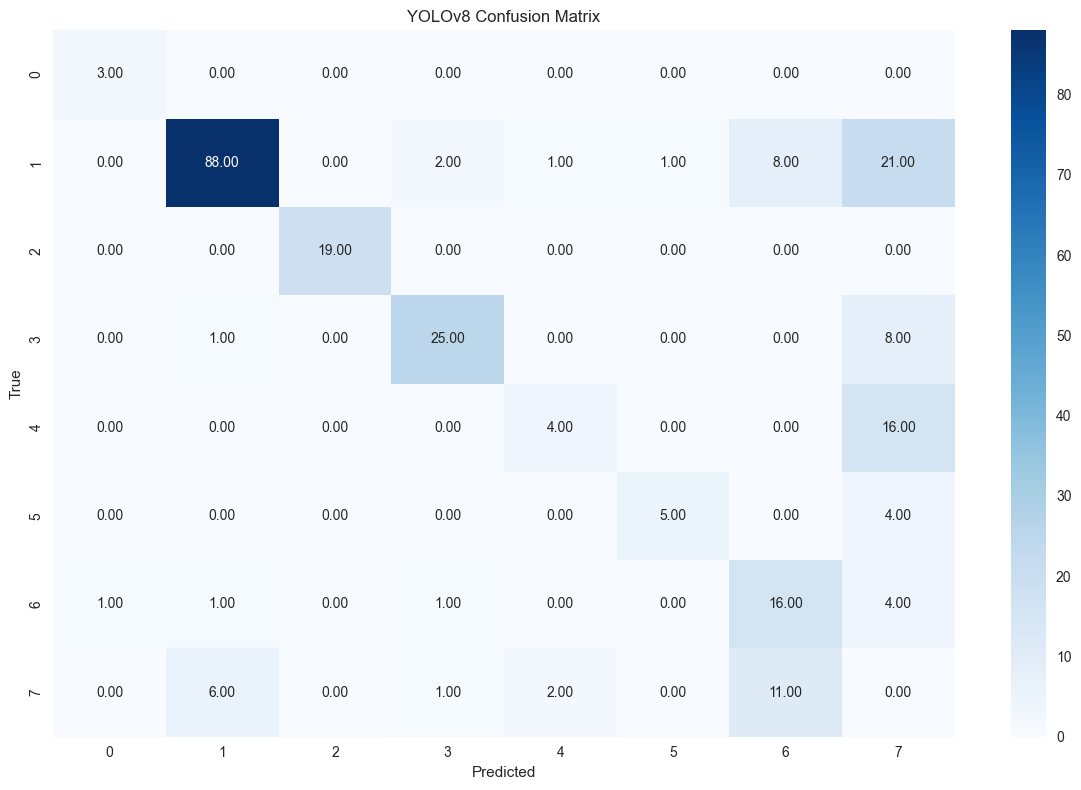

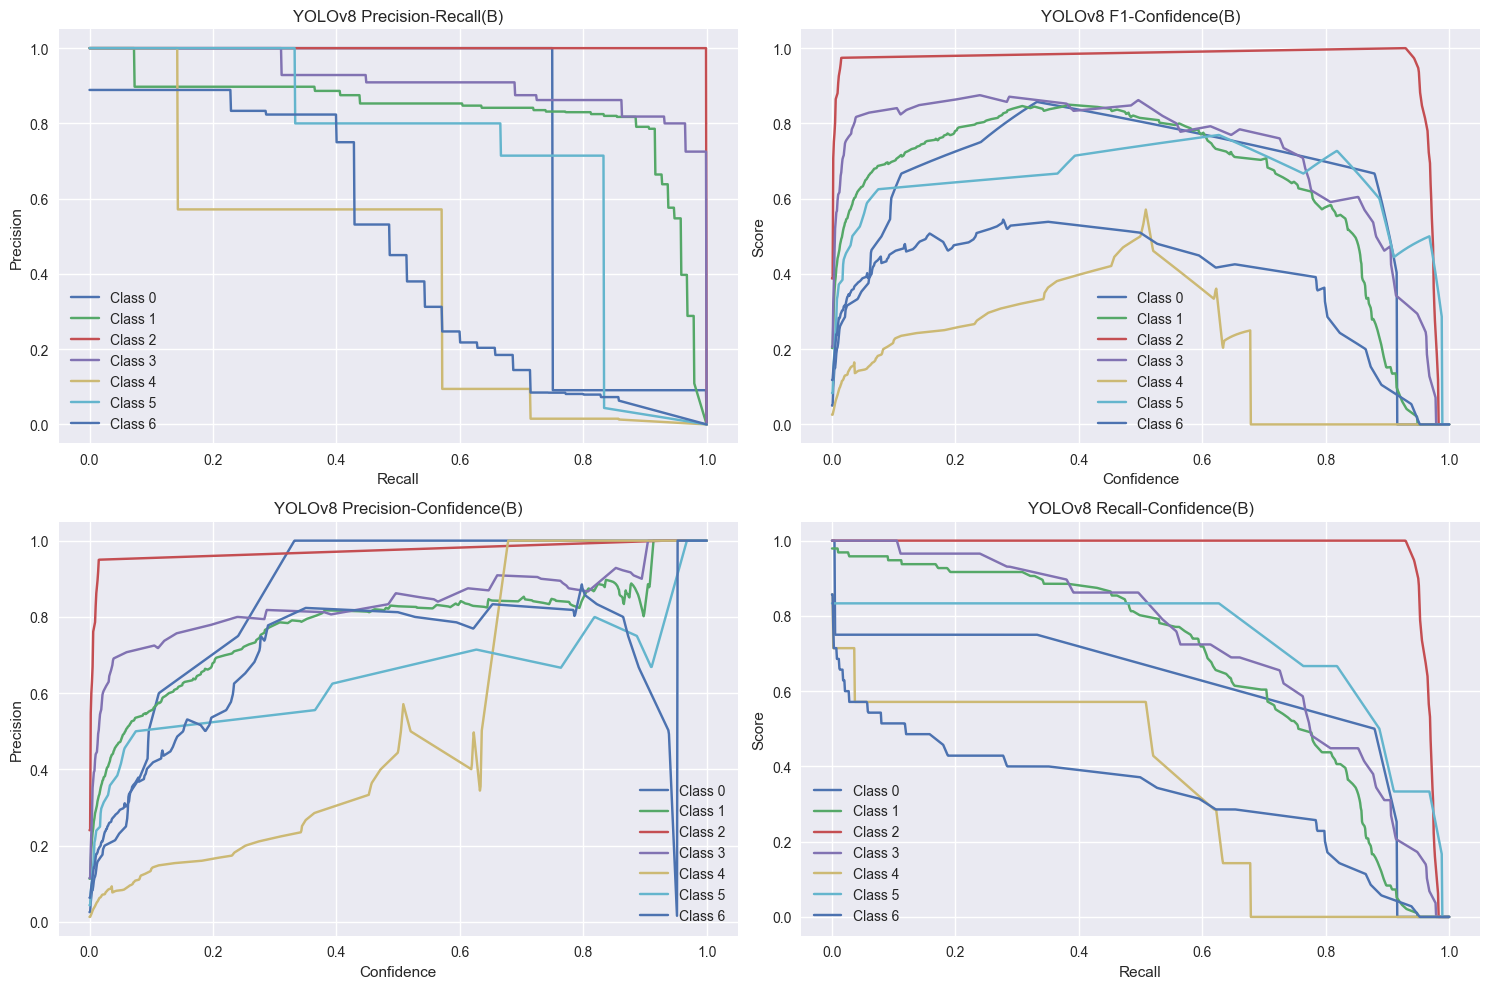

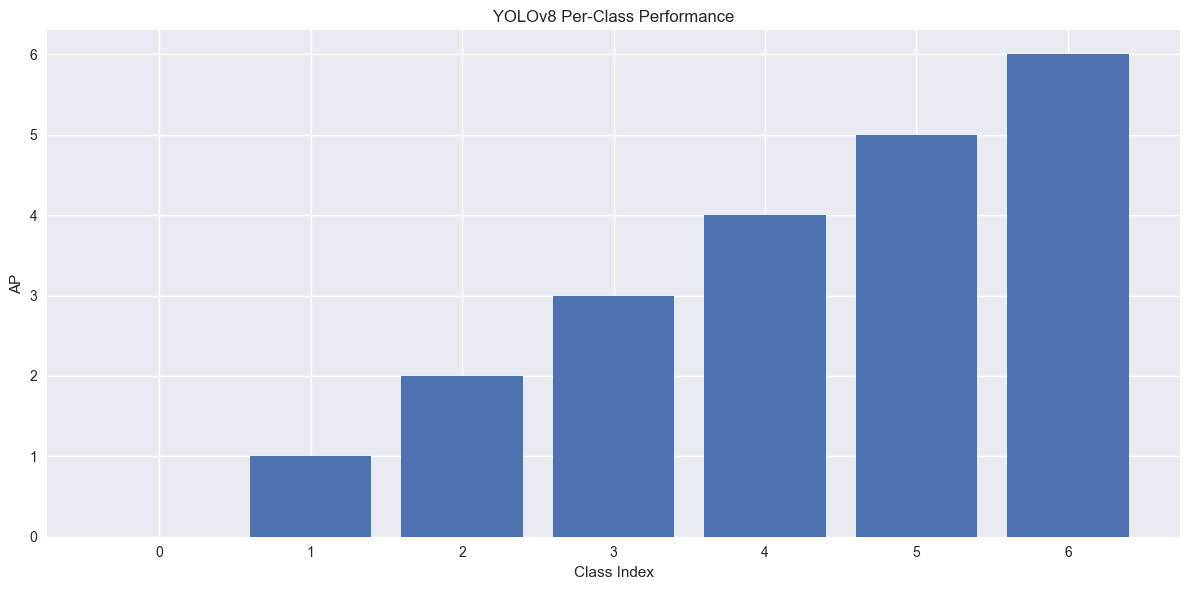

In [6]:
yolo8_metrics = validate_yolo_model(
    'runs/train/yolov8_exp_20250118_173358/weights/best.pt',
    'YOLOv8'
)

### Model #2 YOLOv9


Analyzing YOLOv9
Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLOv9s summary (fused): 486 layers, 7,169,797 parameters, 0 gradients, 26.7 GFLOPs


val: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\valid\labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


                   all         61        196      0.825      0.711      0.757      0.498
        Bacterial Spot          3          4      0.953       0.75      0.749      0.349
          Early_Blight         31         96      0.741      0.833      0.837      0.477
               Healthy         19         19      0.972          1      0.995      0.951
           Late_blight         13         29      0.787      0.763      0.912      0.743
             Leaf Mold          4          7      0.744      0.286       0.46      0.233
           Target_Spot          5          6      0.691      0.833      0.813      0.507
            black spot         21         35      0.891      0.514      0.536      0.224
Speed: 2.2ms preprocess, 18.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\val2

Performance Metrics:
mAP50: 0.757
mAP50-95: 0.498


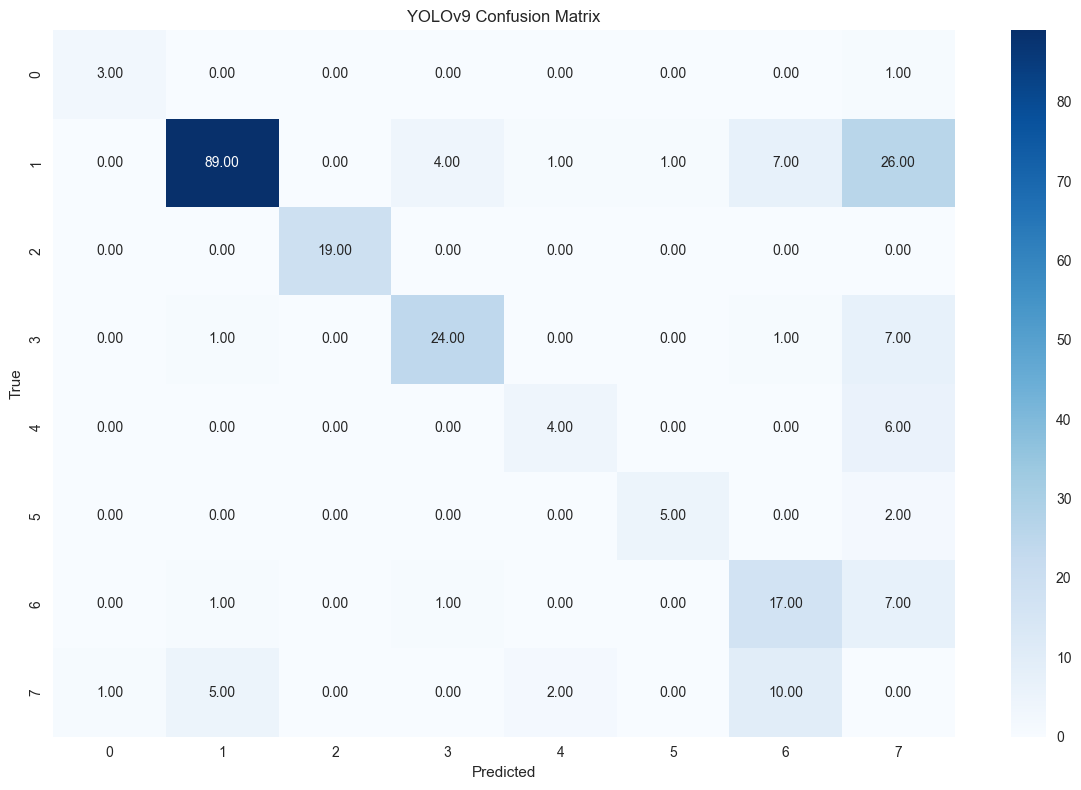

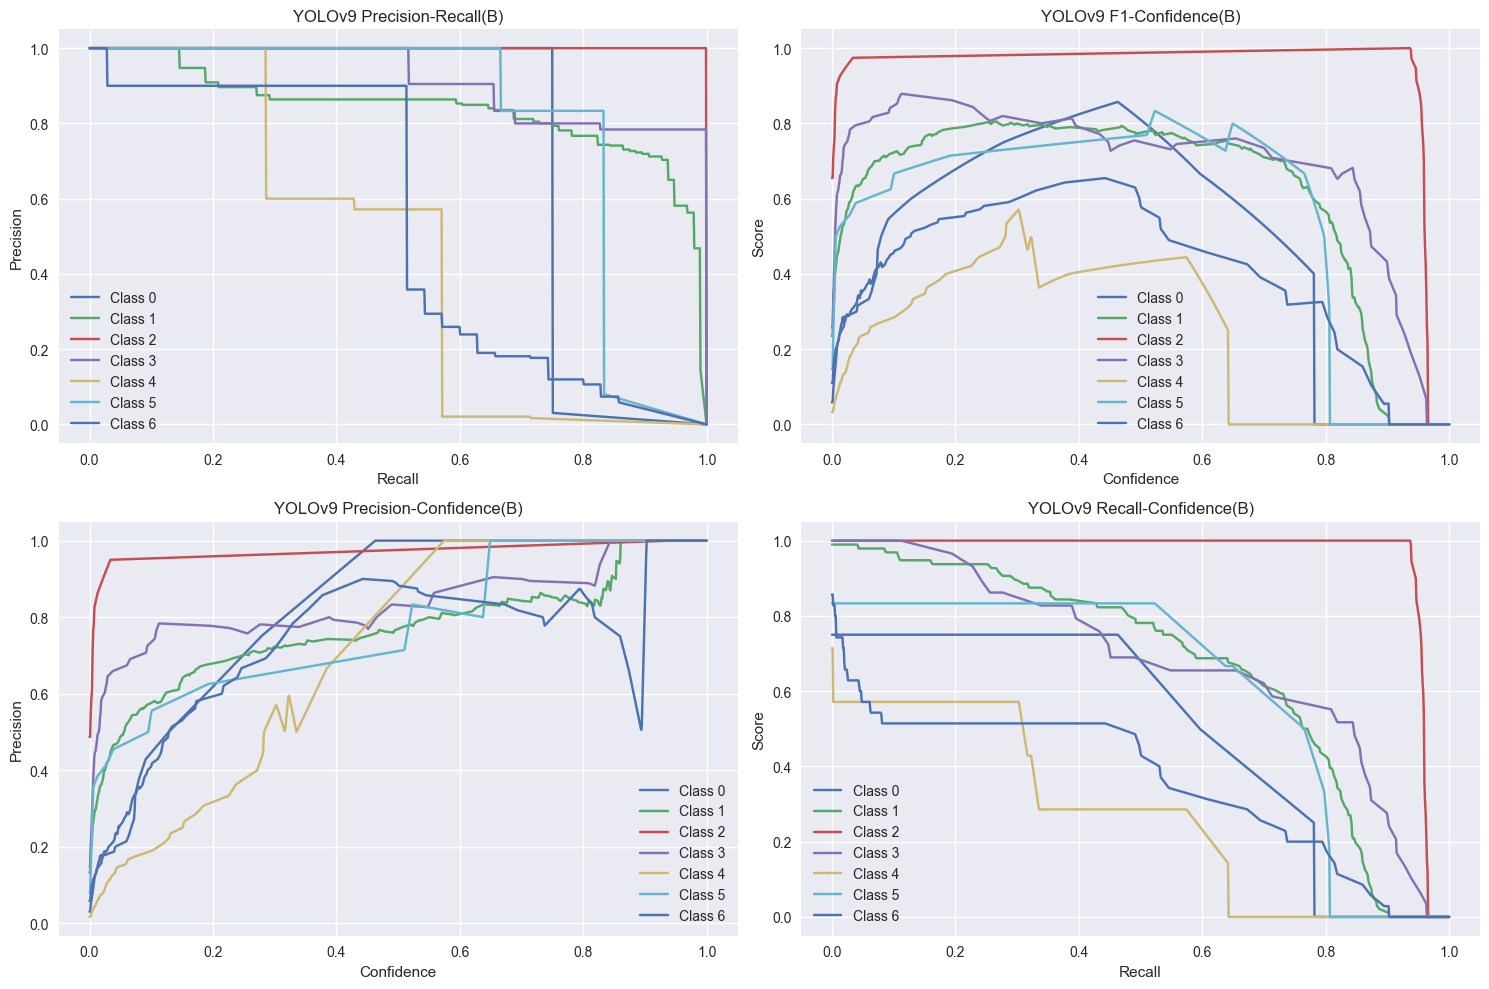

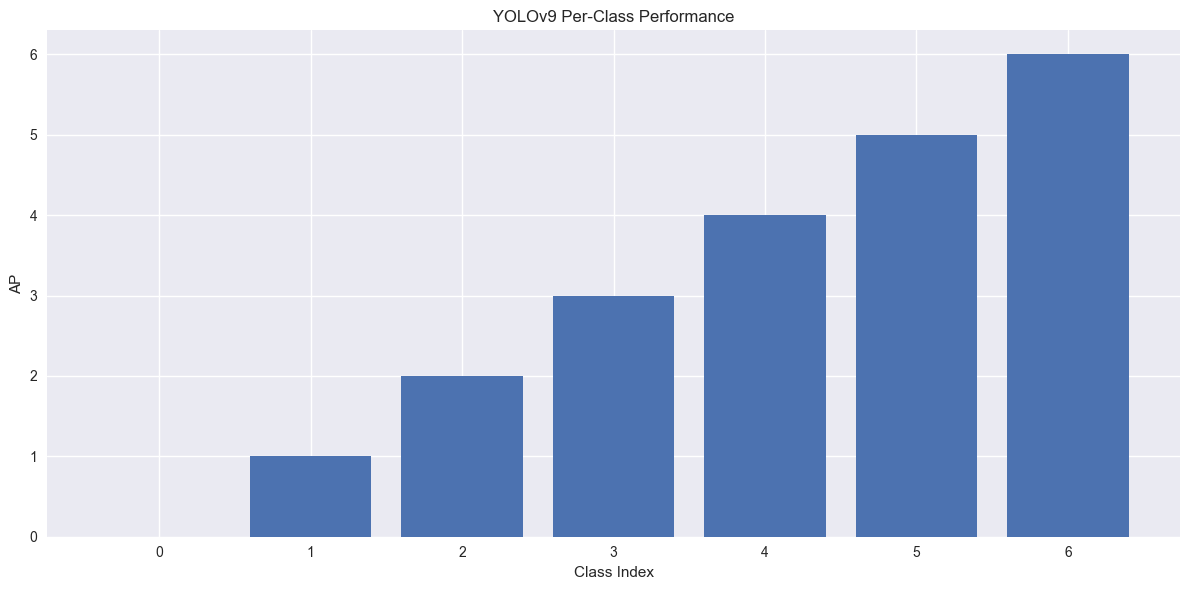

In [7]:
yolo9_metrics = validate_yolo_model(
    'runs/train/yolov9_exp_20250118_181530/weights/best.pt',
    'YOLOv9'
)

### Model #3 YOLO11


Analyzing YOLO11
Ultralytics 8.3.63  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)
YOLO11s summary (fused): 238 layers, 9,415,509 parameters, 0 gradients, 21.3 GFLOPs


val: Scanning D:\ai-projects-portfolio\tomato-leaf-disease-detection\tomato-leaf-diseases\valid\labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100%|██████████| 61/61 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


                   all         61        196      0.782       0.73      0.757      0.498
        Bacterial Spot          3          4       0.93       0.75      0.747      0.373
          Early_Blight         31         96      0.703      0.833      0.819      0.469
               Healthy         19         19      0.926          1      0.995      0.905
           Late_blight         13         29      0.887       0.81      0.885      0.703
             Leaf Mold          4          7      0.788      0.429      0.518      0.326
           Target_Spot          5          6      0.478      0.833       0.81      0.484
            black spot         21         35      0.762      0.458      0.523      0.228
Speed: 1.8ms preprocess, 9.4ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs\detect\val3

Performance Metrics:
mAP50: 0.757
mAP50-95: 0.498


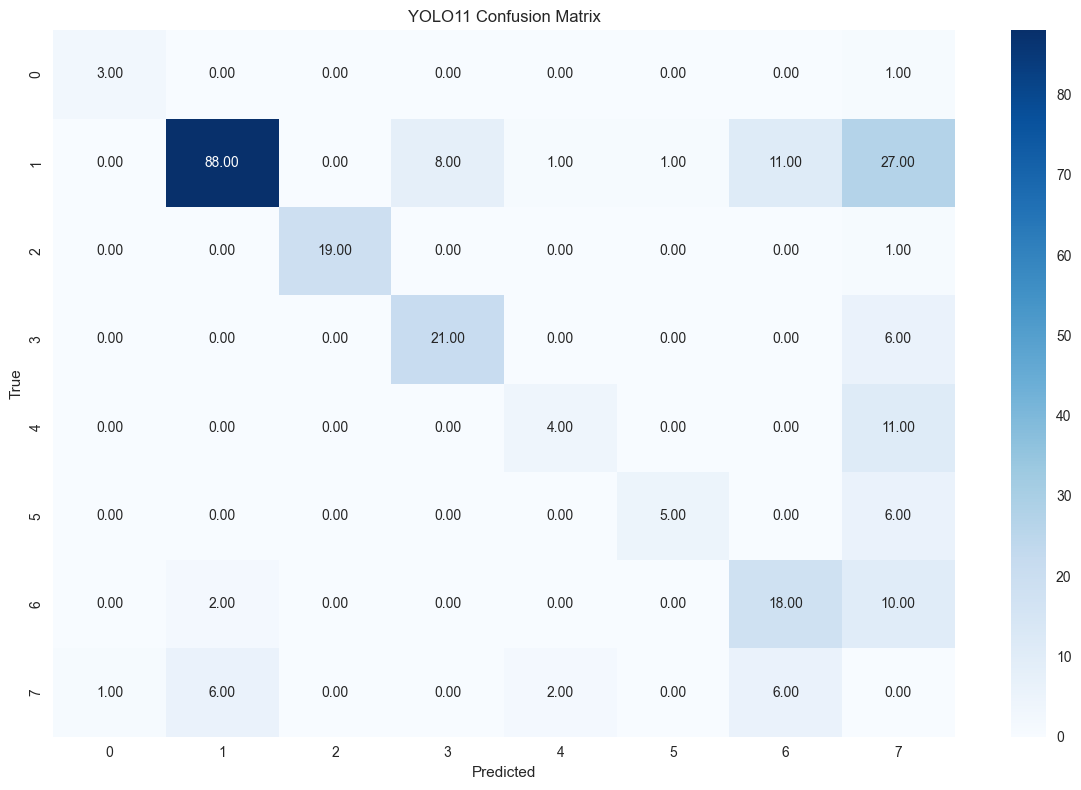

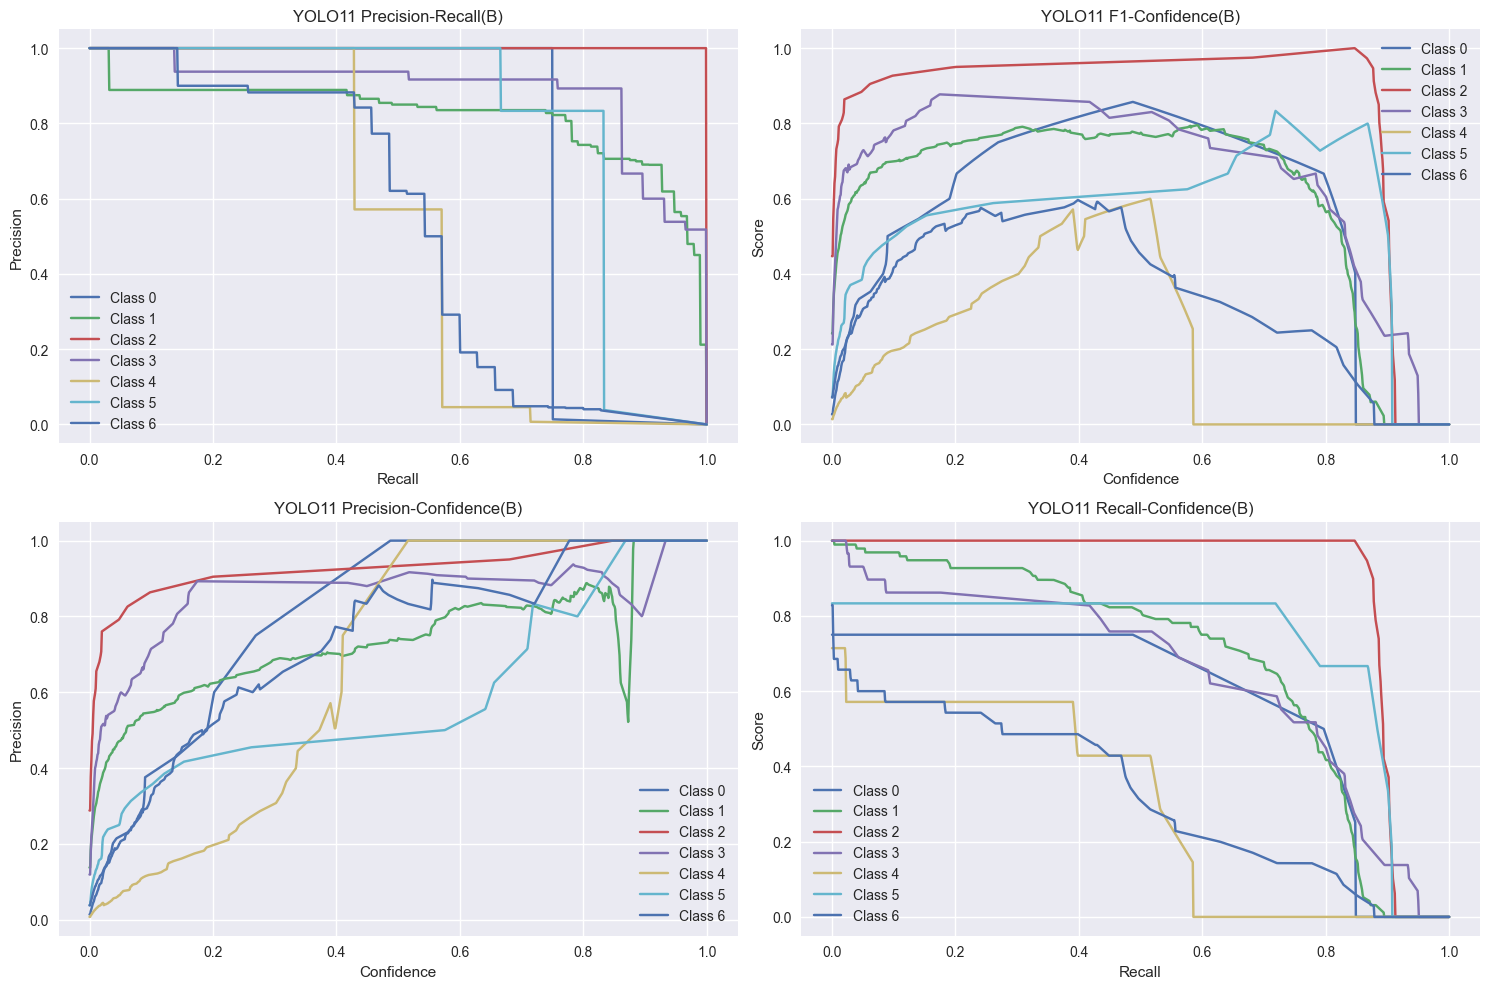

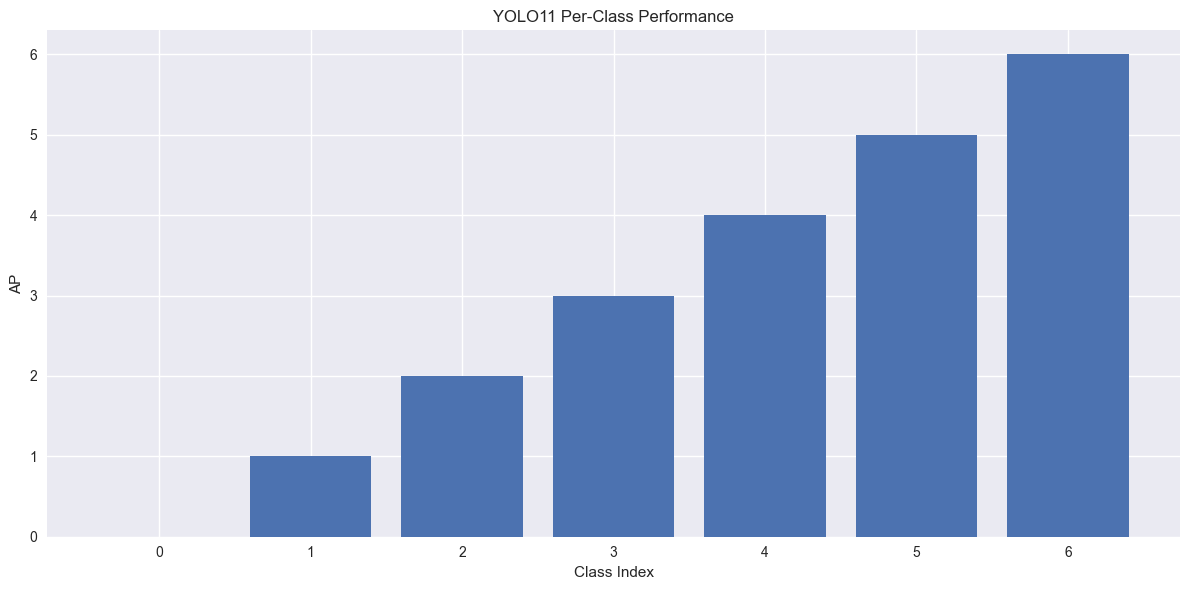

In [8]:
yolo11_metrics = validate_yolo_model(
    'runs/train/yolov11_exp_20250118_201956/weights/best.pt',
    'YOLO11'
)